# Function Calling with Grok API

## Step 1: Install Required Packages

Run this cell to install LangChain, the OpenAI integration (which works with Grok's compatible API), and Requests (for API calls).

In [1]:
!pip install -q langchain langchain_openai requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.1 MB/s eta 0:00:00


## Step 2: Import Libraries and Set Up Your API Key

We'll import the necessary modules and set up the Grok model via its API. Replace `'your-api-key-here'` with your actual xAI API key.

In [2]:
import os
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
import requests
from datetime import datetime
import json
from google.colab import userdata

os.environ["XAI_API_KEY"] = userdata.get('grokapi')

# Set up the Grok model using ChatOpenAI (Grok API is OpenAI-compatible)
llm = ChatOpenAI(
    base_url="https://api.x.ai/v1",
    api_key=os.environ["XAI_API_KEY"],
    model="grok-3-mini",  # Use the appropriate Grok model name (check https://docs.x.ai for latest)
    temperature=0,  # Low temperature for consistent tool calling
    streaming=False,  # Non-streaming for simplicity
)

**Quick Explanation:**
- `ChatOpenAI` is used with a custom `base_url` to point to xAI's API endpoint.
- Grok's API is compatible with OpenAI's format, so this works seamlessly.
- `temperature=0` makes the model more deterministic (good for beginners).
- We're using non-streaming mode to get full responses at once. Note: Grok streams function calls in a single chunk.

## Step 3: Understand Function Calling

**What is Function Calling?**
- LLMs like Grok can't access the internet or real-time data directly.
- Function Calling lets the LLM "call" a predefined function (tool) with parameters.
- Example: User asks "What's the weather in Hong Kong?" → Grok calls a `get_current_weather` tool → Tool fetches data from an API → Grok summarizes it.

In LangChain with Grok API:
- Define tools with the `@tool` decorator (includes name, description, and parameters).
- "Bind" the tool to the LLM so it knows when/how to use it.
- Invoke the LLM with a user query, and it handles the rest!

Our tool will use the **Hong Kong Observatory (HKO) Open Data Weather API** to get real-time weather (e.g., temperature, humidity).

**Grok-Specific Notes:**
- Grok supports parallel function calling by default (multiple tools in one response).
- Use `tool_choice` to control behavior: 'auto' (default), 'required', specific function, or 'none' to disable.
- Tools are defined in the request body and can be referenced by ID in responses.

### Grok Function Calling Flow
Here's a diagram of the function calling process:
![Function Call Flow](https://docs.x.ai/assets/docs/guides/function-calling/function-call.png)

### Example Local Server Setup
If you're setting up a local server for testing:
![Local Server](https://docs.x.ai/assets/docs/guides/function-calling/local-server.png)

### New Request Body Example
An example of the request body when calling the API:
![New Request Body](https://docs.x.ai/assets/docs/guides/function-calling/new-request-body.png)

### Responding Request Body Example
An example of how to respond with tool results:
![Responding Request Body](https://docs.x.ai/assets/docs/guides/function-calling/responding-request-body.png)

## Step 4: Define the "Get Current Weather" Tool

We'll create a tool that calls the HKO API for current weather reports (`dataType=rhrread`). It's Hong Kong-specific, so no location parameter needed for simplicity.

The tool fetches JSON data and returns a formatted string.

**Explaining Pydantic and Raw Dictionary Definitions:**

- **Pydantic**: This is a Python library for data validation and settings management using type hints. In LangChain, when you use `@tool` with type-annotated arguments (e.g., `place: str`), it automatically generates a JSON schema for the tool using Pydantic models under the hood. This reduces errors by enforcing structure and types (e.g., ensuring 'place' is a string). It's great for complex tools with multiple params.

- **Raw Dictionary**: If you don't want to use Pydantic, you can define tools as plain Python dictionaries with a JSON schema. This is more manual but flexible—no dependencies on Pydantic. Example schema: `{'type': 'function', 'function': {'name': 'get_current_weather', 'description': 'Get weather...', 'parameters': {'type': 'object', 'properties': {'place': {'type': 'string'}}, 'required': ['place']}}}`. Pass a list of such dicts to `llm.bind_tools([tool_dict])`.

We'll use the Pydantic way (@tool) for simplicity, but I'll show the raw dict equivalent below.

In [3]:
@tool
def get_current_weather(place: str) -> str:
    """
    Get the current weather in a given place (e.g., 'Hong Kong').

    This tool uses the Hong Kong Observatory API to fetch real-time data like temperature and humidity.
    For now, it only works for places in Hong Kong.

    Args:
        place (str): The place name (e.g., "Hong Kong").

    Returns:
        str: A summary of the current weather.
    """
    if "hong kong" not in place.lower():
        return "Sorry, this tool only supports weather for Hong Kong locations."

    # HKO API endpoint for current weather report
    url = "https://data.weather.gov.hk/weatherAPI/opendata/weather.php"
    params = {
        "dataType": "rhrread",
        "lang": "en"  # English
    }

    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()  # Raise error for bad status
        data = response.json()

        # Extract key info (corrected paths based on actual API structure)
        update_time = data.get("updateTime", "Unknown")
        temperature_data = data.get("temperature", {}).get("data", [])
        humidity_data = data.get("humidity", {}).get("data", [])
        warnings = data.get("warningMessage", []) or data.get("specialWxTips", [])

        # Get first station's temp and humidity (e.g., King's Park or HKO)
        temp = temperature_data[0]["value"] if temperature_data else "N/A"
        hum = humidity_data[0]["value"] if humidity_data else "N/A"

        summary = f"Current weather in Hong Kong (reported at {update_time}):\n"
        summary += f"- Temperature: {temp}°C\n"
        summary += f"- Humidity: {hum}%\n"

        if warnings:
            summary += f"- Warnings/Tips: {'; '.join(warnings)}\n"

        return summary

    except Exception as e:
        return f"Error fetching weather: {str(e)}"

# Alternative: Raw Dictionary Definition (no @tool or Pydantic)
get_current_weather_dict = {
    "type": "function",
    "function": {
        "name": "get_current_weather",
        "description": "Get the current weather in a given place (e.g., 'Hong Kong'). This tool uses the Hong Kong Observatory API.",
        "parameters": {
            "type": "object",
            "properties": {
                "place": {
                    "type": "string",
                    "description": "The place name (e.g., \"Hong Kong\")."
                }
            },
            "required": ["place"]
        }
    }
}

**Quick Explanation:**
- `@tool` turns the function into a LangChain tool using Pydantic for schema. The docstring describes it for the LLM.
- For raw dict: Use this if avoiding Pydantic; it's a JSON schema that LangChain can bind directly.
- We use `requests.get` to call the HKO API (base URL from docs).
- Parse the JSON response (structure from HKO docs: nested `data` with `temperature`, `humidity`, etc.).
- Return a human-readable string. In a real app, you'd handle more fields!

Test the tool standalone:

In [4]:
# Quick test of the tool
print(get_current_weather.invoke({"place": "Hong Kong"}))

Current weather in Hong Kong (reported at 2025-09-23T09:02:00+08:00):
- Temperature: 29°C
- Humidity: 69%
- Warnings/Tips: The Tropical Cyclone Signal No. 3 has been issued.



## Step 5: Bind the Tool to the LLM

Now, "bind" the tool to our LLM. This tells the model it can use `get_current_weather` when needed. We'll use the Pydantic version, but you could bind the dict instead: `llm.bind_tools([get_current_weather_dict])`.

In [5]:
# Bind the tool to the LLM (Pydantic version)
llm_with_tools = llm.bind_tools([get_current_weather])

# Alternative: Bind raw dict
# llm_with_tools = llm.bind_tools([get_current_weather_dict])

# Print the tool schema directly (what the LLM sees)
print(get_current_weather.get_input_schema())

<class 'langchain_core.utils.pydantic.get_current_weather'>


**What happens under the hood?**
- The LLM gets the tool's schema (name, description, parameters).
- When you query, the LLM decides: "Do I need this tool?" If yes, it outputs a "tool call" with args.
- LangChain executes the tool and feeds the result back to the LLM for a final response.

**Grok-Specific:** Parallel calls are enabled by default; set `parallel_function_calling: "false"` in API params if needed (via extra kwargs in LangChain).

## Step 6: Create a Simple Chain and Run Examples

We'll use a fixed step-by-step approach with JSON forcing for tool decisions, adapted from the original. This ensures clean handling.

In [6]:
# Fixed Step-by-Step Forcing: JSON-Only Tool Decision + Clean Summary
from langchain_core.messages import HumanMessage, SystemMessage
import json

def force_tool_via_json(user_input: str):
    # Phase 1: Prompt for JSON-only tool decision (strict format)
    json_prompt = SystemMessage(content="""You are a tool-calling assistant. Analyze the user query and respond
    **ONLY** with valid JSON in this exact format:
    {
      "use_tool": true/false,  // true if query is about CURRENT weather in Hong Kong
      "tool_name": "get_current_weather" or null,
      "args": {"place": "string"} or null  // e.g., {"place": "Hong Kong"}
    }
    Do NOT output any other text, explanations, or markdown. If not current weather, set use_tool=false.""")

    messages = [json_prompt, HumanMessage(content=user_input)]

    try:
        json_response = llm_with_tools.invoke(messages)  # Use bound LLM for schema awareness
        json_str = json_response.content.strip()  # Extract content
        print("Raw JSON Output:", json_str)  # Debug: See what it outputs

        # Phase 2: Parse and execute
        tool_plan = json.loads(json_str)
        if tool_plan.get("use_tool") and tool_plan.get("tool_name") == "get_current_weather":
            args = tool_plan.get("args", {})
            tool_result = get_current_weather.invoke(args)
            print("Tool Executed! Result:", tool_result)

            # Phase 3: NEW fresh messages for summarization (no JSON prompt!)
            summary_system = SystemMessage(content="""You are a helpful weather assistant.
            Summarize the provided tool result in a natural, friendly response to the user's query.
            Include key details like temperature, humidity, and warnings. Keep it concise and engaging.""")

            # Fresh chain: User query + tool result only
            summary_messages = [
                summary_system,
                HumanMessage(content=user_input),
                HumanMessage(content=f"Tool result: {tool_result}")
            ]
            final_response = llm.invoke(summary_messages)  # Use unbound LLM for free-form text
            return final_response.content
        else:
            return "No tool needed for this query."
    except json.JSONDecodeError:
        return "Error: LLM didn't output valid JSON. Try rephrasing."
    except Exception as e:
        return f"Error: {e}"

# Test it
user_query = "What's the current weather in Hong Kong?"
result = force_tool_via_json(user_query)
print("Final Summary:", result)

Raw JSON Output: {
  "use_tool": true,
  "tool_name": "get_current_weather",
  "args": {
    "place": "Hong Kong"
  }
}
Tool Executed! Result: Current weather in Hong Kong (reported at 2025-09-23T09:02:00+08:00):
- Temperature: 29°C
- Humidity: 69%
- Warnings/Tips: The Tropical Cyclone Signal No. 3 has been issued.

Final Summary: Hey there! The current weather in Hong Kong is quite warm at 29°C with 69% humidity, making it feel a bit sticky. Just a heads up, Tropical Cyclone Signal No. 3 is in effect, so stay safe and keep an eye on updates. If you're heading out, consider securing loose items and avoiding unnecessary travel! 😊


## Step 7: What's Next?

Congrats! You've built your first Function Calling app with Grok API. Experiment with more tools or modes like `tool_choice='required'`.

**Resources:**
- [xAI Grok API Docs: Function Calling](https://docs.x.ai/docs/guides/function-calling)
- [LangChain Docs: Tools](https://python.langchain.com/docs/modules/agents/tools/)
- [HKO API Full Docs](https://www.hko.gov.hk/en/weatherAPI/doc/files/HKO_Open_Data_API_Documentation.pdf)
- Questions? Ask in the comments!

Happy coding! 🌤️

In [13]:
!pip install -q xai-sdk

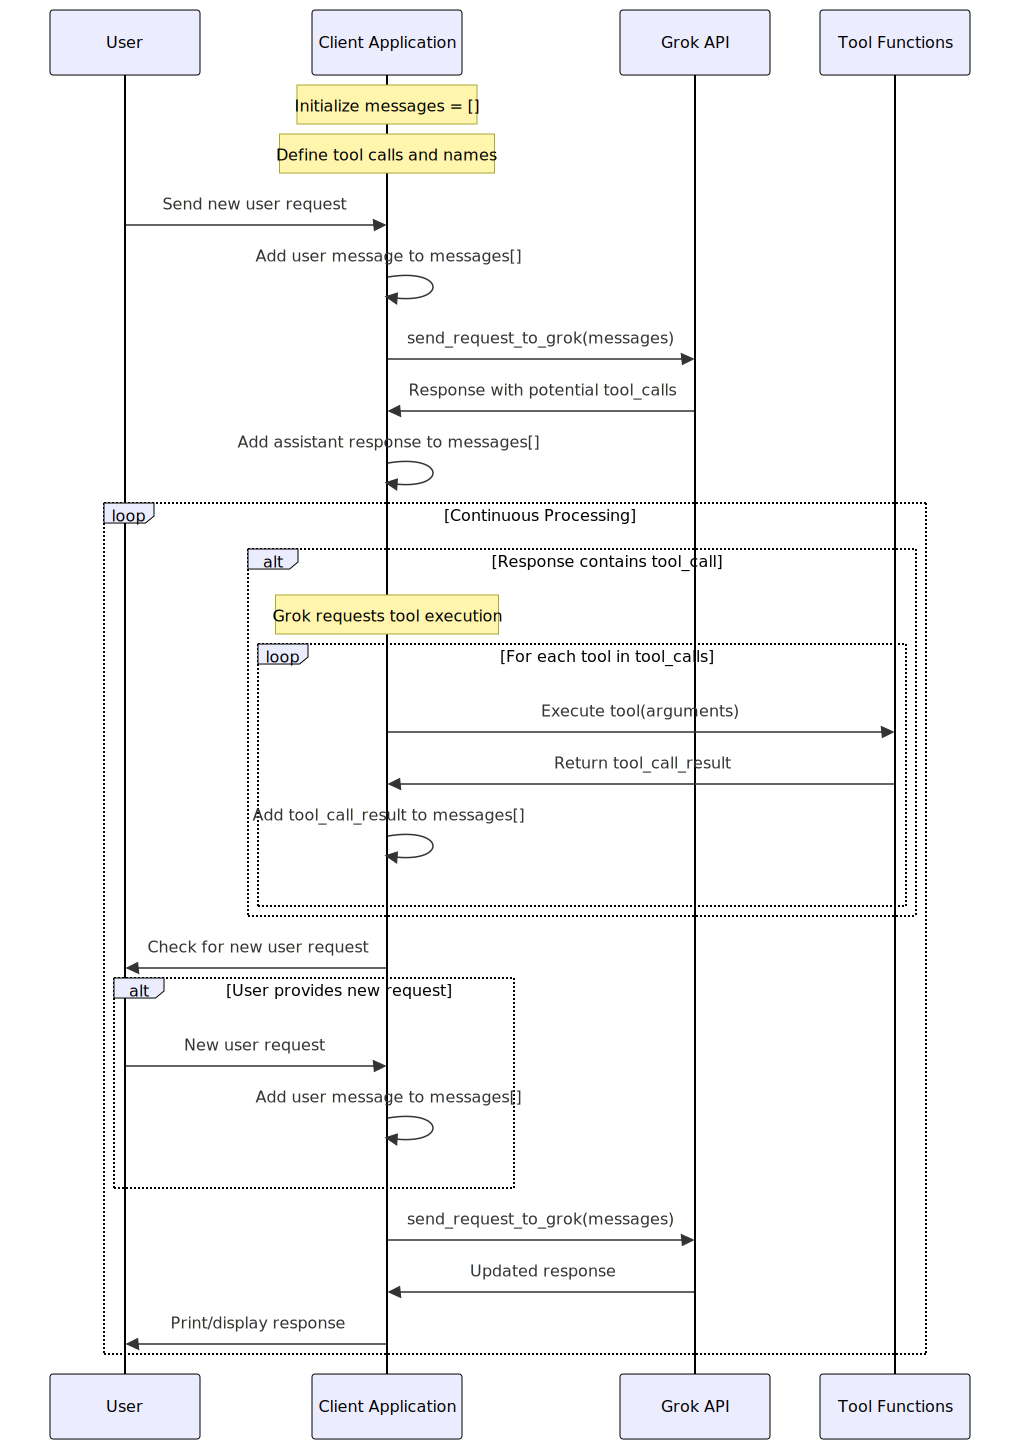

In [16]:
from IPython.display import SVG, display

# Use the raw GitHub URL
url = "https://raw.githubusercontent.com/enoch-sit/publicimages/main/toolcalls.svg"
display(SVG(url=url))

In [17]:
import os
import json

from xai_sdk import Client
from xai_sdk.chat import tool, tool_result, user

client = Client(api_key=os.getenv('XAI_API_KEY'))
chat = client.chat.create(model="grok-3-mini")

### Preparation - Define tool functions and function mapping
Define tool functions as callback functions to be called when model requests them in response.
Normally, these functions would either retrieve data from a database, or call another API endpoint, or perform some actions. For demonstration purposes, we hardcode to return 59° Fahrenheit/15° Celsius as the temperature, and 15,000 feet as the cloud ceiling.
The parameters definition will be sent in the initial request to Grok, so Grok knows what tools and parameters are available to be called.
To reduce human error, you can define the tools partially using Pydantic.

The get_current_ceiling function from the xAI Grok API tutorial is an example tool designed to retrieve the current cloud ceiling height for a specified location, which is directly related to weather as a key meteorological measurement. In weather contexts, a cloud ceiling refers to the height above the ground (or water) of the base of the lowest layer of clouds that covers more than half the sky (often more than 50% or 4/8 oktas). This data is commonly reported in aviation weather reports (e.g., METARs) to assess visibility, flight safety, and conditions like overcast skies, but it can also inform general forecasting for precipitation, fog, or atmospheric stability. In the tutorial, the function is hardcoded for demonstration (returning a fixed value like 15,000 feet with a "broken" cloud type), but in practice, it would query a weather API or database to provide real-time cloud ceiling data as part of broader weather too

#### Function definition using Pydantic:

In [18]:
from typing import Literal

from pydantic import BaseModel, Field

class TemperatureRequest(BaseModel):
    location: str = Field(description="The city and state, e.g. San Francisco, CA")
    unit: Literal["celsius", "fahrenheit"] = Field(
        "fahrenheit", description="Temperature unit"
    )

class CeilingRequest(BaseModel):
    location: str = Field(description="The city and state, e.g. San Francisco, CA")

def get_current_temperature(request: TemperatureRequest):
    temperature = 59 if request.unit.lower() == "fahrenheit" else 15
    return {
        "location": request.location,
        "temperature": temperature,
        "unit": request.unit,
    }

def get_current_ceiling(request: CeilingRequest):
    return {
        "location": request.location,
        "ceiling": 15000,
        "ceiling_type": "broken",
        "unit": "ft",
    }

# Generate the JSON schema from the Pydantic models

get_current_temperature_schema = TemperatureRequest.model_json_schema()
get_current_ceiling_schema = CeilingRequest.model_json_schema()

# Definition of parameters with Pydantic JSON schema

tool_definitions = [
    tool(
        name="get_current_temperature",
        description="Get the current temperature in a given location",
        parameters=get_current_temperature_schema,
    ),
    tool(
        name="get_current_ceiling",
        description="Get the current cloud ceiling in a given location",
        parameters=get_current_ceiling_schema,
    ),
]

#### Function definition using raw dictionary:

In [19]:
from typing import Literal

def get_current_temperature(location: str, unit: Literal["celsius", "fahrenheit"] = "fahrenheit"):
    temperature = 59 if unit == "fahrenheit" else 15
    return {
        "location": location,
        "temperature": temperature,
        "unit": unit,
    }

def get_current_ceiling(location: str):
    return {
        "location": location,
        "ceiling": 15000,
        "ceiling_type": "broken",
        "unit": "ft",
    }

# Raw dictionary definition of parameters

tool_definitions = [
    tool(
        name="get_current_temperature",
        description="Get the current temperature in a given location",
        parameters={
            "type": "object",
            "properties": {
                "location": {
                    "type": "string",
                    "description": "The city and state, e.g. San Francisco, CA",
                },
                "unit": {
                    "type": "string",
                    "enum": ["celsius", "fahrenheit"],
                    "default": "fahrenheit",
                },
            },
            "required": ["location"],
        },
    ),
    tool(
        name="get_current_ceiling",
        description="Get the current cloud ceiling in a given location",
        parameters={
            "type": "object",
            "properties": {
                "location": {
                    "type": "string",
                    "description": "The city and state, e.g. San Francisco, CA",
                }
            },
            "required": ["location"],
        },
    ),
]

Create a string -> function mapping, so we can call the function when model sends it's name. e.g.

In [20]:
tools_map = {
    "get_current_temperature": get_current_temperature,
    "get_current_ceiling": get_current_ceiling,
}

### 1. Send initial message
With all the functions defined, it's time to send our API request to Grok!
Now before we send it over, let's look at how the generic request body for a new task looks like.
Here we assume a previous tool call has Note how the tool call is referenced three times:

* By id and name in "Mesage History" assistant's first response

* By tool_call_id in "Message History" tool's content

* In the tools field of the request body

Now we compose the request messages in the request body and send it over to Grok. Grok should return a response that asks us for a tool call.

In [21]:
chat = client.chat.create(
    model="grok-3-mini",
    tools=tool_definitions,
    tool_choice="auto",
)
chat.append(user("What's the temperature like in San Francisco?"))
response = chat.sample()

# You can inspect the response tool calls which contains a tool call

print(response.tool_calls)

[id: "call_81007743"
function {
  name: "get_current_temperature"
  arguments: "{\"location\":\"San Francisco, CA\"}"
}
]


### 2. Run tool functions if Grok asks tool call and append function returns to message
We retrieve the tool function names and arguments that Grok wants to call, run the functions, and add the result to messages.
At this point, you can choose to only respond to tool call with results or add a new user message request.
The tool message would contain the following:

```json
{
    "role": "tool",
    "content": <json string of tool function's returned object>,
    "tool_call_id": <tool_call.id included in the tool call response by Grok>,
}
```

The request body that we try to assemble and send back to Grok. Note it looks slightly different from the new task request body:
The corresponding code to append messages:

In [23]:
# Append assistant message including tool calls to messages
chat.append(response)

# Check if there is any tool calls in response body

# You can also wrap this in a function to make the code cleaner

if response.tool_calls:
    for tool_call in response.tool_calls:

        # Get the tool function name and arguments Grok wants to call
        function_name = tool_call.function.name
        function_args = json.loads(tool_call.function.arguments)

        # Call one of the tool function defined earlier with arguments
        result = tools_map[function_name](**function_args)

        # Append the result from tool function call to the chat message history
        chat.append(tool_result(json.dumps(result)))

### 3. Send the tool function returns back to the model to get the response

In [24]:
response = chat.sample()
print(response.content)

The current temperature in San Francisco, CA is 59°F.


### 4. (Optional) Continue the conversation
You can continue the conversation following Step 2. Otherwise you can terminate.

### Function calling modes
By default, the model will automatically decide whether a function call is necessary and select which functions to call, as determined by the tool_choice: "auto" setting.
We offer three ways to customize the default behavior:

1. To force the model to always call one or more functions, you can set tool_choice: "required". The model will then always call function. Note this could force the model to hallucinate parameters.

2. To force the model to call a specific function, you can set tool_choice: {"type": "function", "function": {"name": "my_function"}}.

3. To disable function calling and force the model to only generate a user-facing message, you can either provide no tools, or set tool_choice: "none".

### Parallel function calling
By default, parallel function calling is enabled, so you can process multiple function calls in one request/response cycle. When two or more tool calls are required, all of the tool call requests will be included in the response body. You can disable it by setting parallel_function_calling : "false".